
**Goal**: Use CLIP (Contrastive Language-Image Pre-training) to evaluate and select the best generated images.

---

##  What is CLIP?

**CLIP** is a vision-language model that learns a **joint embedding space**:
- Text and images are encoded into the same vector space
- Semantically similar text-image pairs have high cosine similarity
- Trained on 400M image-caption pairs from the internet

### How CLIP Was Trained

**Contrastive Learning**:
1. Given a batch of N (image, caption) pairs
2. Encode all images → image embeddings
3. Encode all captions → text embeddings
4. Learn to maximize similarity for correct pairs, minimize for incorrect pairs

Result: A model that "understands" semantic relationships!

### Why Use CLIP for Diffusion Models?

1. **Text Encoder in SD**: CLIP provides the text embeddings that guide generation
2. **Image Evaluation**: Measure how well a generated image matches the prompt
3. **Reranking**: Generate multiple candidates, select the best one automatically
4. **Quality Control**: Filter out low-quality or misaligned generations

**Runtime**: This notebook takes ~5 minutes to complete.

---

## 1️ Setup & Installation

In [1]:
# Install required packages
!pip install -q diffusers transformers accelerate torch torchvision matplotlib

In [2]:
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

print(" Imports successful!")

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


 Imports successful!


In [3]:
# Check GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    print(f" GPU: {torch.cuda.get_device_name(0)}")
else:
    print(" No GPU detected. Using CPU (slower).")

os.makedirs("../outputs", exist_ok=True)
print(" Output directory ready")

 GPU: Tesla T4
✅ Output directory ready


---

## 2️ Load Stable Diffusion Model

In [4]:
model_id = "runwayml/stable-diffusion-v1-5"

print("Loading Stable Diffusion...")
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    safety_checker=None,
).to(device)

pipe.enable_attention_slicing()
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

print(" Stable Diffusion ready!")

Loading Stable Diffusion...


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its resul

 Stable Diffusion ready!


---

## 3️ Load CLIP Model

In [5]:
# Load CLIP (ViT-B/32 variant - good balance of speed and accuracy)
clip_model_id = "openai/clip-vit-base-patch32"

print("Loading CLIP model...")
clip_model = CLIPModel.from_pretrained(clip_model_id).to(device)
clip_processor = CLIPProcessor.from_pretrained(clip_model_id)

print(" CLIP loaded!")
print(f"   Model: {clip_model_id}")
print(f"   Components:")
print(f"   ├─ Vision Encoder: ViT-B/32 (image → 512-dim vector)")
print(f"   └─ Text Encoder: Transformer (text → 512-dim vector)")

Loading CLIP model...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

CLIPModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
vision_model.embeddings.position_ids | UNEXPECTED |  | 
text_model.embeddings.position_ids   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

The image processor of type `CLIPImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

 CLIP loaded!
   Model: openai/clip-vit-base-patch32
   Components:
   ├─ Vision Encoder: ViT-B/32 (image → 512-dim vector)
   └─ Text Encoder: Transformer (text → 512-dim vector)


###  CLIP Architecture Overview

```
           Image                     Text
             |                         |
       Vision Encoder             Text Encoder
      (ViT-B/32)                (Transformer)
             |                         |
         [512-dim]                 [512-dim]
             \                       /
              \                     /
               Cosine Similarity
                      |
                 Score (0-1)
```

High score = image matches text semantically!

---

## 4️ Compute CLIP Similarity

In [6]:
def compute_clip_score(images, prompts, clip_model, clip_processor, device):
    """
    Compute CLIP similarity scores between images and text prompts.

    Args:
        images (list of PIL.Image): List of images to evaluate
        prompts (list of str): List of text prompts (usually same prompt repeated)
        clip_model: CLIP model
        clip_processor: CLIP processor
        device: torch device

    Returns:
        np.ndarray: CLIP scores for each image (shape: [num_images])
    """
    # Prepare inputs
    inputs = clip_processor(
        text=prompts,
        images=images,
        return_tensors="pt",
        padding=True,
    ).to(device)

    # Get embeddings
    with torch.no_grad():
        outputs = clip_model(**inputs)
        image_embeds = outputs.image_embeds  # [num_images, 512]
        text_embeds = outputs.text_embeds    # [num_prompts, 512]

    # Normalize embeddings (for cosine similarity)
    image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)
    text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)

    # Compute cosine similarity
    # Since we usually have one prompt for all images, we use the first text embedding
    similarity = (image_embeds @ text_embeds[0]).cpu().numpy()

    return similarity



###  Understanding Cosine Similarity

**Cosine similarity** measures the angle between two vectors:

$$\text{similarity} = \frac{A \cdot B}{||A|| \times ||B||}$$

- **1.0**: Perfectly aligned (same direction)
- **0.0**: Orthogonal (no relationship)
- **-1.0**: Opposite (negatively related)

For CLIP:
- **>0.3**: Good alignment
- **>0.35**: Very good alignment
- **<0.25**: Poor alignment (likely mismatched)

---

## 5️ Batch Generation & Reranking

In [7]:
def generate_and_rank(prompt, num_candidates=4, num_inference_steps=25, guidance_scale=7.5):
    """
    Generate multiple images and rank them by CLIP score.

    Args:
        prompt (str): Text prompt
        num_candidates (int): Number of images to generate
        num_inference_steps (int): Denoising steps
        guidance_scale (float): Guidance scale

    Returns:
        list of PIL.Image, list of float: Images and their CLIP scores (sorted by score)
    """
    print(f"Generating {num_candidates} candidates for: '{prompt}'")

    # Generate multiple images with different seeds
    images = []
    for i in range(num_candidates):
        with torch.autocast(device):
            result = pipe(
                prompt,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
            )
        images.append(result.images[0])
        print(f"  Generated {i+1}/{num_candidates}")

    # Compute CLIP scores
    print("Computing CLIP scores...")
    prompts = [prompt] * num_candidates  # Same prompt for all images
    scores = compute_clip_score(images, prompts, clip_model, clip_processor, device)

    # Sort by score (descending)
    sorted_indices = np.argsort(scores)[::-1]
    sorted_images = [images[i] for i in sorted_indices]
    sorted_scores = scores[sorted_indices]

    return sorted_images, sorted_scores

print(" Batch generation & ranking function ready!")

 Batch generation & ranking function ready!


Generating 4 candidates for: 'a majestic lion standing on a cliff at sunset, wildlife photography'


  0%|          | 0/25 [00:00<?, ?it/s]

  Generated 1/4


  0%|          | 0/25 [00:00<?, ?it/s]

  Generated 2/4


  0%|          | 0/25 [00:00<?, ?it/s]

  Generated 3/4


  0%|          | 0/25 [00:00<?, ?it/s]

  Generated 4/4
Computing CLIP scores...


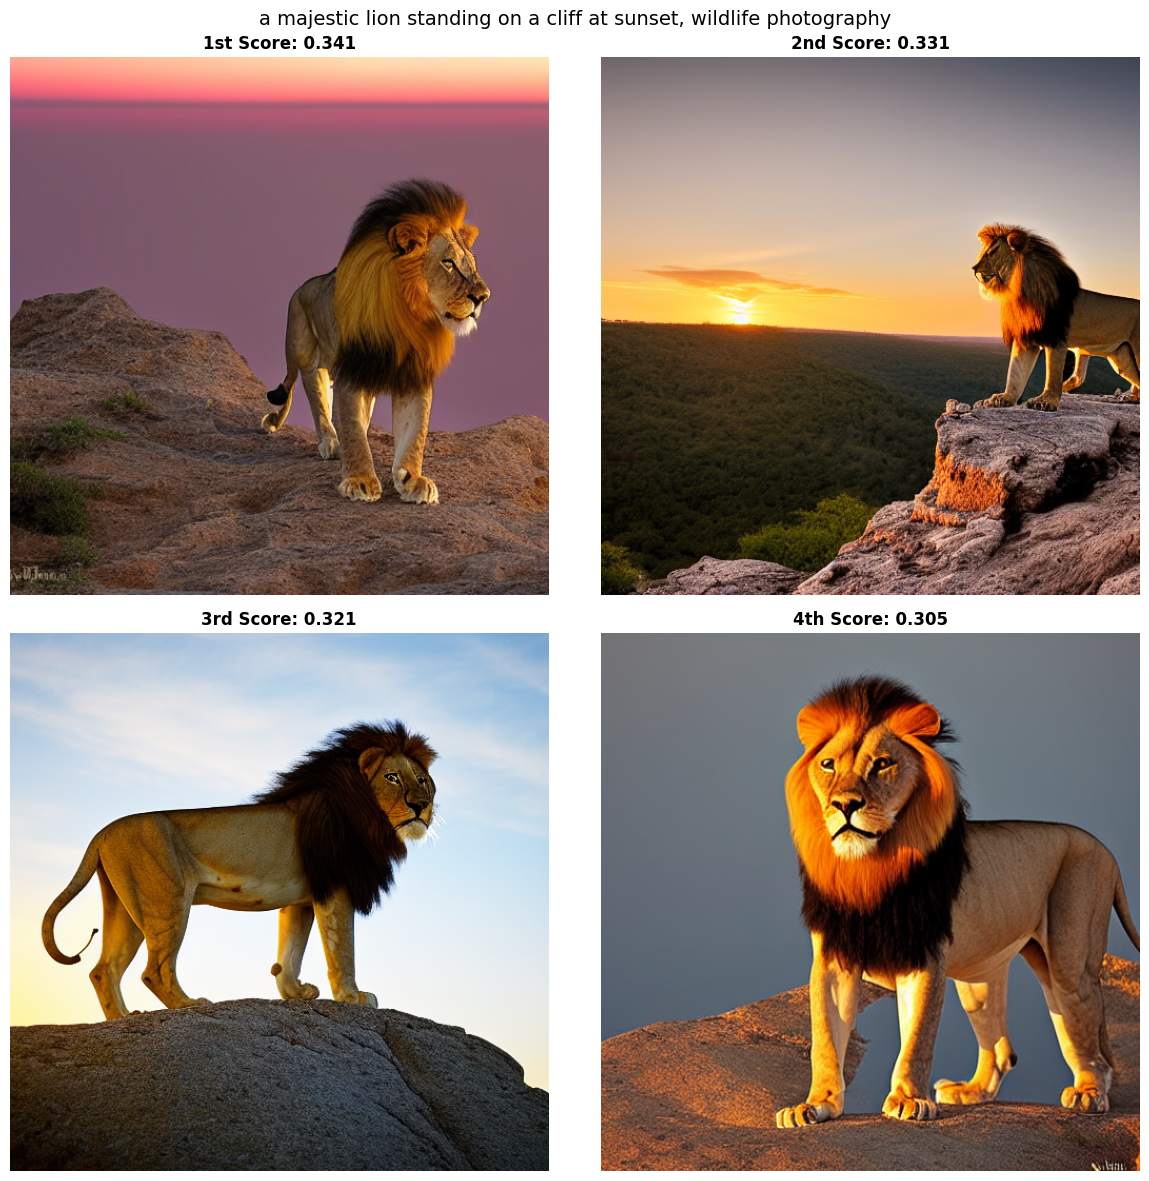


 Best image has CLIP score: 0.341
   Worst image has CLIP score: 0.305
   Improvement: 11.8%


In [8]:
# Example 1: Simple prompt
prompt = "a majestic lion standing on a cliff at sunset, wildlife photography"

images, scores = generate_and_rank(prompt, num_candidates=4)

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, (img, score) in enumerate(zip(images, scores)):
    axes[idx].imshow(img)
    axes[idx].axis('off')
    rank = "1st" if idx == 0 else "2nd" if idx == 1 else "3rd" if idx == 2 else "4️th"
    axes[idx].set_title(f"{rank} Score: {score:.3f}", fontsize=12, fontweight='bold')

plt.suptitle(prompt, fontsize=14)
plt.tight_layout()
plt.show()

print(f"\n Best image has CLIP score: {scores[0]:.3f}")
print(f"   Worst image has CLIP score: {scores[-1]:.3f}")
print(f"   Improvement: {(scores[0] - scores[-1]) / scores[-1] * 100:.1f}%")

---

## 6️ Multi-Prompt Selection

Which image best matches which prompt?

In [9]:
# Generate images with different styles
base_prompt = "a castle"
style_prompts = [
    "a castle, medieval fantasy art",
    "a castle, modern minimalist architecture",
    "a castle, cyberpunk neon style",
    "a castle, watercolor painting",
]

print("Generating images with different styles...\n")
generated_images = []

for style_prompt in style_prompts:
    print(f"Generating: {style_prompt}")
    with torch.autocast(device):
        img = pipe(style_prompt, num_inference_steps=25, guidance_scale=7.5).images[0]
    generated_images.append(img)

print("\n All images generated!")

Generating images with different styles...

Generating: a castle, medieval fantasy art


  0%|          | 0/25 [00:00<?, ?it/s]

Generating: a castle, modern minimalist architecture


  0%|          | 0/25 [00:00<?, ?it/s]

Generating: a castle, cyberpunk neon style


  0%|          | 0/25 [00:00<?, ?it/s]

Generating: a castle, watercolor painting


  0%|          | 0/25 [00:00<?, ?it/s]


 All images generated!


Computing CLIP similarity matrix...



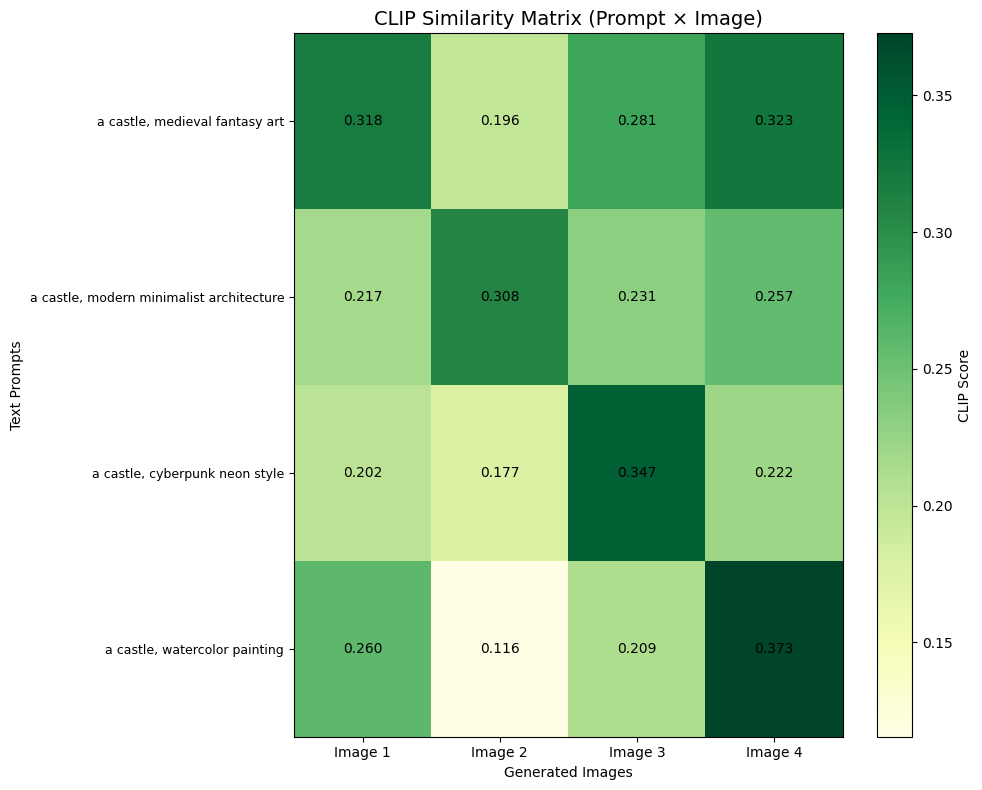


 Diagonal values should be highest (correct prompt-image pairs)!


In [10]:
# Compute CLIP scores for all prompt-image pairs
print("Computing CLIP similarity matrix...\n")

similarity_matrix = np.zeros((len(style_prompts), len(generated_images)))

for i, prompt in enumerate(style_prompts):
    scores = compute_clip_score(
        generated_images,
        [prompt] * len(generated_images),
        clip_model,
        clip_processor,
        device
    )
    similarity_matrix[i, :] = scores

# Display heatmap
fig, ax = plt.subplots(figsize=(10, 8))

im = ax.imshow(similarity_matrix, cmap='YlGn', aspect='auto')
ax.set_xticks(range(len(generated_images)))
ax.set_yticks(range(len(style_prompts)))
ax.set_xticklabels([f"Image {i+1}" for i in range(len(generated_images))])
ax.set_yticklabels(style_prompts, fontsize=9)
ax.set_xlabel("Generated Images")
ax.set_ylabel("Text Prompts")
ax.set_title("CLIP Similarity Matrix (Prompt × Image)", fontsize=14)

# Add text annotations
for i in range(len(style_prompts)):
    for j in range(len(generated_images)):
        text = ax.text(j, i, f"{similarity_matrix[i, j]:.3f}",
                      ha="center", va="center", color="black", fontsize=10)

plt.colorbar(im, ax=ax, label="CLIP Score")
plt.tight_layout()
plt.show()

print("\n Diagonal values should be highest (correct prompt-image pairs)!")

---

## 7️ Filtering Low-Quality Generations

In [11]:
# Generate images with a potentially ambiguous prompt
ambiguous_prompt = "a cool scene"

print(f"Generating with vague prompt: '{ambiguous_prompt}'\n")
vague_images, vague_scores = generate_and_rank(ambiguous_prompt, num_candidates=6)

# Set a threshold for acceptable quality
threshold = 0.27  # Typical threshold for CLIP

accepted_images = [img for img, score in zip(vague_images, vague_scores) if score >= threshold]
rejected_images = [img for img, score in zip(vague_images, vague_scores) if score < threshold]

print(f"\n Accepted: {len(accepted_images)} images (score ≥ {threshold})")
print(f"   Rejected: {len(rejected_images)} images (score < {threshold})")

# Visualize filtering
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (img, score) in enumerate(zip(vague_images, vague_scores)):
    axes[idx].imshow(img)
    axes[idx].axis('off')

    status = " ACCEPTED" if score >= threshold else " REJECTED"
    color = 'green' if score >= threshold else 'red'
    axes[idx].set_title(f"{status}\nScore: {score:.3f}", fontsize=11, color=color, fontweight='bold')

plt.suptitle(f"Prompt: '{ambiguous_prompt}' | Threshold: {threshold}", fontsize=14)
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

---

## 8️ Practical Application: Best-of-N Sampling

In [12]:
def best_of_n_generation(prompt, n=8, num_inference_steps=25, guidance_scale=7.5):
    """
    Generate N images and return only the best one according to CLIP.

    This is a common production pattern for improving output quality.
    """
    print(f" Best-of-{n} sampling for: '{prompt}'\n")

    images, scores = generate_and_rank(
        prompt,
        num_candidates=n,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale
    )

    best_image = images[0]
    best_score = scores[0]

    print(f"\n Best image score: {best_score:.3f}")
    print(f"   Average score: {np.mean(scores):.3f}")
    print(f"   Worst score: {scores[-1]:.3f}")

    return best_image, best_score, images, scores

# Example usage
production_prompt = "a serene japanese garden with cherry blossoms, spring, photorealistic"
best_img, best_score, all_imgs, all_scores = best_of_n_generation(production_prompt, n=6)

 Best-of-6 sampling for: 'a serene japanese garden with cherry blossoms, spring, photorealistic'

Generating 6 candidates for: 'a serene japanese garden with cherry blossoms, spring, photorealistic'


  0%|          | 0/25 [00:00<?, ?it/s]

  Generated 1/6


  0%|          | 0/25 [00:00<?, ?it/s]

  Generated 2/6


  0%|          | 0/25 [00:00<?, ?it/s]

  Generated 3/6


  0%|          | 0/25 [00:00<?, ?it/s]

  Generated 4/6


  0%|          | 0/25 [00:00<?, ?it/s]

  Generated 5/6


  0%|          | 0/25 [00:00<?, ?it/s]

  Generated 6/6
Computing CLIP scores...

 Best image score: 0.349
   Average score: 0.333
   Worst score: 0.319


/tmp/ipython-input-3666198786.py:31: UserWarning: Glyph 129351 (\N{FIRST PLACE MEDAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3666198786.py:31: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129351 (\N{FIRST PLACE MEDAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


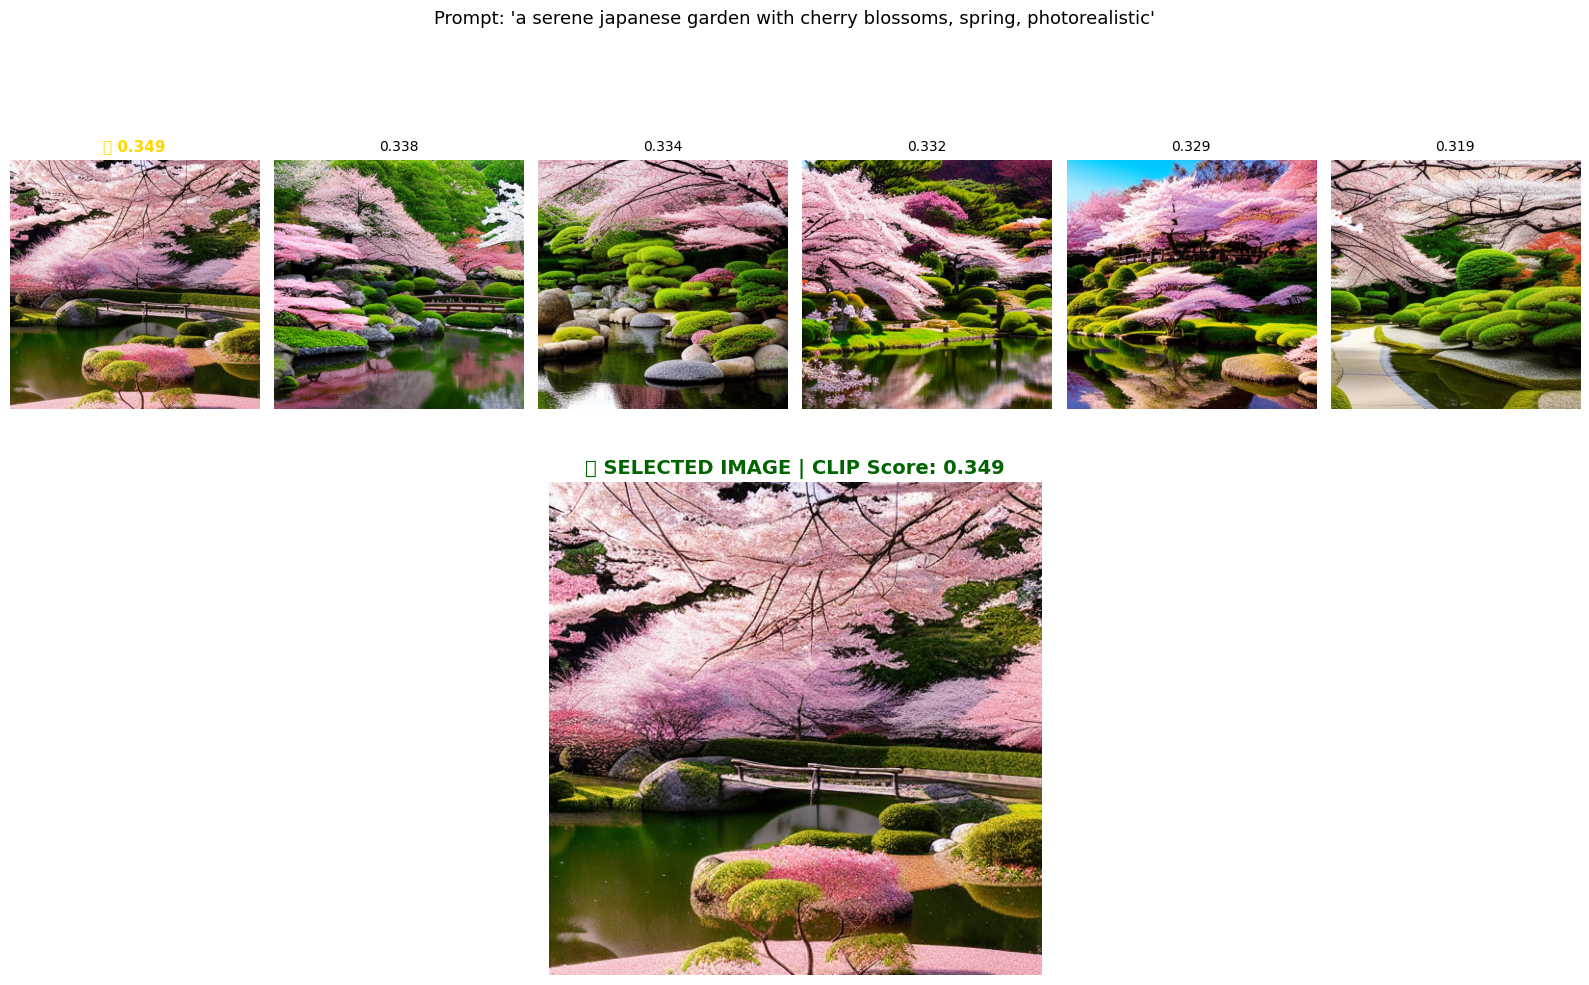

 Saved best image to outputs/best_of_n_result.png


In [13]:
# Visualize the selection process
fig = plt.figure(figsize=(16, 10))

# Top row: All candidates with scores
for idx in range(6):
    ax = plt.subplot(2, 6, idx + 1)
    ax.imshow(all_imgs[idx])
    ax.axis('off')

    if idx == 0:
        ax.set_title(f"🥇 {all_scores[idx]:.3f}", fontsize=11, color='gold', fontweight='bold')
        ax.spines['bottom'].set_color('gold')
        ax.spines['top'].set_color('gold')
        ax.spines['left'].set_color('gold')
        ax.spines['right'].set_color('gold')
        ax.spines['bottom'].set_linewidth(3)
        ax.spines['top'].set_linewidth(3)
        ax.spines['left'].set_linewidth(3)
        ax.spines['right'].set_linewidth(3)
    else:
        ax.set_title(f"{all_scores[idx]:.3f}", fontsize=10)

# Bottom row: Best image (larger)
ax_best = plt.subplot(2, 1, 2)
ax_best.imshow(best_img)
ax_best.axis('off')
ax_best.set_title(f"🏆 SELECTED IMAGE | CLIP Score: {best_score:.3f}",
                  fontsize=14, fontweight='bold', color='darkgreen')

plt.suptitle(f"Prompt: '{production_prompt}'", fontsize=13)
plt.tight_layout()
plt.show()

# Save best image
best_img.save("../outputs/best_of_n_result.png")
print(" Saved best image to outputs/best_of_n_result.png")